In [ ]:
# 1. Pre-processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score
import optuna
import shap

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [32]:
data = pd.read_excel(r'fraud_data.xlsx')
data.head()

,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud
0,PAYMENT,Indonesia,9839.64,C1231006815,170136.0,160296.36,M1979787155,9,0,Current,3/1/2018,Morning,0
1,PAYMENT,India,1864.28,C1666544295,21249.0,19384.72,M2044282225,10,0,Savings,5/1/2018,Morning,0
2,TRANSFER,India,181.00,C1305486145,181.0,0.00,C553264065,2,0,Current,7/1/2018,Morning,1
3,CASH_OUT,Australia,181.00,C840083671,181.0,0.00,C38997010,1,0,Current,6/1/2018,Afternoon,1
4,PAYMENT,Australia,11668.14,C2048537720,41554.0,29885.86,M1230701703,17,0,Current,6/1/2018,Morning,0


In [33]:
pd.set_option('display.max_columns', None)
data.describe(include='all')

,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud
count,10125,10125,1.012500e+04,10125,1.012500e+04,1.012500e+04,10125,10125.000000,10125.0,10125,10125,10125,10125.000000
unique,5,135,NaN,10119,NaN,NaN,6494,NaN,NaN,2,14,3,NaN
top,PAYMENT,Estados Unidos,NaN,C10001825,NaN,NaN,C985934102,NaN,NaN,Savings,6/1/2018,Afternoon,NaN
freq,5544,1282,NaN,7,NaN,NaN,68,NaN,NaN,6995,1453,3628,NaN
mean,NaN,NaN,1.048873e+05,NaN,8.836949e+05,9.046314e+05,NaN,10.513580,0.0,NaN,NaN,NaN,0.011654
std,NaN,NaN,2.706366e+05,NaN,2.124555e+06,2.170130e+06,NaN,5.809393,0.0,NaN,NaN,NaN,0.107330
min,NaN,NaN,2.390000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000,0.0,NaN,NaN,NaN,0.000000
25%,NaN,NaN,4.397580e+03,NaN,1.290000e+02,0.000000e+00,NaN,6.000000,0.0,NaN,NaN,NaN,0.000000
50%,NaN,NaN,1.279882e+04,NaN,2.136300e+04,1.019179e+04,NaN,10.000000,0.0,NaN,NaN,NaN,0.000000
75%,NaN,NaN,1.143818e+05,NaN,1.724320e+05,1.707442e+05,NaN,16.000000,0.0,NaN,NaN,NaN,0.000000


In [34]:
for i in data.columns:
        print(data[i].value_counts())
        print()

type
PAYMENT     5544
CASH_IN     1953
CASH_OUT    1336
TRANSFER     946
DEBIT        346
Name: count, dtype: int64

branch
Estados Unidos          1282
Francia                  734
Mexico                   670
Australia                633
Alemania                 499
                        ... 
Bosnia y Herzegovina       1
Oman                       1
Tunez                      1
Sierra Leona               1
Yibuti                     1
Name: count, Length: 135, dtype: int64

amount
25975.86    5
18627.02    2
2806.00     2
181.00      2
25071.46    2
           ..
2571.91     1
4471.58     1
12462.77    1
20401.83    1
5337.77     1
Name: count, Length: 10077, dtype: int64

nameOrig
C10001825      7
C1231006815    1
C1666544295    1
C1305486145    1
C840083671     1
              ..
C499929119     1
C1295781070    1
C72615054      1
C1225706699    1
C1639296014    1
Name: count, Length: 10119, dtype: int64

oldbalanceOrg
0.0           2452
10500000.0       7
10300000.0       6
122.0

In [14]:
print(data['branch'].value_counts(dropna=False).to_string())



branch
Estados Unidos                     1282
Francia                             734
Mexico                              670
Australia                           633
Alemania                            499
China                               453
Brasil                              444
India                               391
Reino Unido                         370
Indonesia                           315
Italia                              310
Espana                              193
El Salvador                         186
Republica Dominicana                184
Turquia                             183
Honduras                            183
Filipinas                           170
Guatemala                           154
Cuba                                152
Nicaragua                           142
Colombia                            105
Nueva Zelanda                       101
Argentina                            98
Nigeria                              96
Paises Bajos                     

In [35]:

country_to_continent = {
    # North America
    'Estados Unidos': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',
    'Panama': 'North America',
    'Honduras': 'North America',
    'El Salvador': 'North America',
    'Nicaragua': 'North America',
    'Republica Dominicana': 'North America',
    'Costa Rica': 'North America',
    'Guatemala': 'North America',
    'Cuba': 'North America',
    'Bahamas': 'North America',
    'Haiti': 'North America',
    'Jamaica': 'North America',
    'Trinidad y Tobago': 'North America',
    # South America
    'Brasil': 'South America',
    'Argentina': 'South America',
    'Colombia': 'South America',
    'Venezuela': 'South America',
    'Peru': 'South America',
    'Chile': 'South America',
    'Bolivia': 'South America',
    'Ecuador': 'South America',
    'Paraguay': 'South America',
    'Uruguay': 'South America',
    # Europe
    'Alemania': 'Europe',
    'Francia': 'Europe',
    'Italia': 'Europe',
    'Espana': 'Europe',
    'Suecia': 'Europe',
    'Noruega': 'Europe',
    'Portugal': 'Europe',
    'Austria': 'Europe',
    'Belgica': 'Europe',
    'Finlandia': 'Europe',
    'Polonia': 'Europe',
    'Irlanda': 'Europe',
    'Republica Checa': 'Europe',
    'Rumania': 'Europe',
    'Ucrania': 'Europe',
    'Russia': 'Europe',
    'Ucrania': 'Europe',
    # Asia
    'India': 'Asia',
    'China': 'Asia',
    'Indonesia': 'Asia',
    'Pakistan': 'Asia',
    'Japon': 'Asia',
    'Vietnam': 'Asia',
    'Corea del Sur': 'Asia',
    'Iran': 'Asia',
    'Irak': 'Asia',
    'Filipinas': 'Asia',
    'Malasia': 'Asia',
    'Nepal': 'Asia',
    'Camboya': 'Asia',
    # Africa
    'Nigeria': 'Africa',
    'Egipto': 'Africa',
    'Sudafrica': 'Africa',
    'Senegal': 'Africa',
    'Marruecos': 'Africa',
    'Angola': 'Africa',
    'Etiopia': 'Africa',
    'Uganda': 'Africa',
    'Camerun': 'Africa',
    'Zimbabue': 'Africa',
    'Sudan': 'Africa',
    # Oceania
    'Australia': 'Oceania',
    'Nueva Zelanda': 'Oceania',
    'Papua Nueva Guinea': 'Oceania',
    # Middle East 
    'Arabia Saudi': 'Asia',
    'Emiratos arabes Unidos': 'Asia',
    'Israel': 'Asia',

}

def map_country_to_continent(country):
    if country in country_to_continent:
        return country_to_continent[country]
    else:
        return 'Other'

data['branch_continent'] = data['branch'].apply(map_country_to_continent)


In [36]:
data

,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud,branch_continent
0,PAYMENT,Indonesia,9839.64,C1231006815,170136.0,160296.36,M1979787155,9,0,Current,3/1/2018,Morning,0,Asia
1,PAYMENT,India,1864.28,C1666544295,21249.0,19384.72,M2044282225,10,0,Savings,5/1/2018,Morning,0,Asia
2,TRANSFER,India,181.00,C1305486145,181.0,0.00,C553264065,2,0,Current,7/1/2018,Morning,1,Asia
3,CASH_OUT,Australia,181.00,C840083671,181.0,0.00,C38997010,1,0,Current,6/1/2018,Afternoon,1,Oceania
4,PAYMENT,Australia,11668.14,C2048537720,41554.0,29885.86,M1230701703,17,0,Current,6/1/2018,Morning,0,Oceania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,PAYMENT,Cuba,337.50,C1494306005,33107.0,32769.50,M1424027000,7,0,Current,3/1/2018,Afternoon,0,North America
10121,PAYMENT,Mexico,5003.57,C1633890169,32769.5,27765.93,M1854745805,11,0,Savings,5/1/2018,Morning,0,North America
10122,PAYMENT,Panama,10424.89,C1026138669,50780.0,40355.11,M1852900317,6,0,Savings,7/1/2018,Night,0,North America
10123,PAYMENT,Mexico,2823.59,C378659213,986.0,0.00,M301812950,12,0,Savings,6/1/2018,Night,0,North America


In [37]:
data['Date of transaction'] = pd.to_datetime(data['Date of transaction'], dayfirst=True)

In [38]:
data['transaction_year'] = data['Date of transaction'].dt.year
data['transaction_month'] = data['Date of transaction'].dt.month
data['transaction_day'] = data['Date of transaction'].dt.day

In [39]:
data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'Date of transaction', 'branch'], axis=1, inplace=True)

In [40]:
data.isnull().sum()

type                 0
amount               0
oldbalanceOrg        0
newbalanceOrig       0
unusuallogin         0
Acct type            0
Time of day          0
isFraud              0
branch_continent     0
transaction_year     0
transaction_month    0
transaction_day      0
dtype: int64

In [41]:
new_data = data.copy()

from sklearn.preprocessing import LabelEncoder

encoders = {}
for i in new_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    new_data[i] = le.fit_transform(new_data[i])
    encoders[i] = le

new_data

,type,amount,oldbalanceOrg,newbalanceOrig,unusuallogin,Acct type,Time of day,isFraud,branch_continent,transaction_year,transaction_month,transaction_day
0,3,9839.64,170136.0,160296.36,9,0,1,0,1,2018,1,3
1,3,1864.28,21249.0,19384.72,10,1,1,0,1,2018,1,5
2,4,181.00,181.0,0.00,2,0,1,1,1,2018,1,7
3,1,181.00,181.0,0.00,1,0,0,1,4,2018,1,6
4,3,11668.14,41554.0,29885.86,17,0,1,0,4,2018,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
10120,3,337.50,33107.0,32769.50,7,0,0,0,3,2018,1,3
10121,3,5003.57,32769.5,27765.93,11,1,1,0,3,2018,1,5
10122,3,10424.89,50780.0,40355.11,6,1,2,0,3,2018,1,7
10123,3,2823.59,986.0,0.00,12,1,2,0,3,2018,1,6


In [42]:
encoders

{'type': LabelEncoder(),
 'Acct type': LabelEncoder(),
 'Time of day': LabelEncoder(),
 'branch_continent': LabelEncoder()}

In [43]:
inputs = new_data.drop('isFraud', axis=1)
output = new_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.3, random_state=42)

In [44]:
inputs_cat = data.drop('isFraud', axis=1)
outputs_cat = data['isFraud']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(inputs_cat, outputs_cat, test_size=0.3, random_state=42)

In [45]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_prob_train = model.predict_proba(X_train)[:, 1]

        roc_prob_train = roc_auc_score(y_train, y_prob_train)
        gini_prob_train = roc_prob_train * 2 - 1
        confusion_matrix_result_train = confusion_matrix(y_train, y_pred_train)
        classification_report_result_train = classification_report(y_train, y_pred_train)

        print(f'Model Performance for {model_name}')
        print('Train Gini prob is', gini_prob_train * 100)
        print(classification_report_result_train)
        print(confusion_matrix_result_train)

        y_pred_test = model.predict(X_test)
        y_prob_test = model.predict_proba(X_test)[:, 1]

        roc_prob_test = roc_auc_score(y_test, y_prob_test)
        gini_prob_test = roc_prob_test * 2 - 1
        confusion_matrix_result_test = confusion_matrix(y_test, y_pred_test)
        classification_report_result_test = classification_report(y_test, y_pred_test)

        print(f'Model Performance for {model_name}')
        print('Test Gini prob is', gini_prob_test * 100)
        print(classification_report_result_test)
        print(confusion_matrix_result_test)

        return [gini_prob_train, gini_prob_test]

    except Exception as e:
        print(f"An error occurred while evaluating the model {model_name}: {e}")
        return None

# 2. Modeling

In [46]:
models = []
    
xgb_model_def = XGBClassifier(random_state=42)
lgb_model_def = LGBMClassifier(random_state=42)
catboost_model_def = CatBoostClassifier(random_state=42)
catboost_model_custom = CatBoostClassifier(cat_features=['type', 'branch_continent', 'Acct type', 'Time of day'], random_state=42)
rf_model_def = RandomForestClassifier(n_estimators=100,random_state=42)

models.extend([
    ('XGBoost', xgb_model_def),
    ('LightGBM', lgb_model_def),
    ('CatBoost', catboost_model_def),
    ('CatBoost_Custom', catboost_model_custom),
    ('Random Forest', rf_model_def)
])

In [47]:
gini_df = pd.DataFrame(columns=['Model', 'Train Gini', 'Test Gini'])

for model_name, model in models:
    if model_name == 'CatBoost_Custom':
        gini_prob = train_and_evaluate_model(model_name, model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)
    else:
        gini_prob = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)

    if gini_prob is not None:
        gini_df = pd.concat([gini_df, pd.DataFrame({'Model': [model_name], 'Train Gini': [gini_prob[0]], 'Test Gini': [gini_prob[1]]})], ignore_index=True)

gini_df_sorted = gini_df.sort_values(by='Test Gini', ascending=False)

Model Performance for XGBoost
Train Gini prob is 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7008
           1       1.00      1.00      1.00        79

    accuracy                           1.00      7087
   macro avg       1.00      1.00      1.00      7087
weighted avg       1.00      1.00      1.00      7087

[[7008    0]
 [   0   79]]
Model Performance for XGBoost
Test Gini prob is 71.60079000692538
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2999
           1       0.83      0.26      0.39        39

    accuracy                           0.99      3038
   macro avg       0.91      0.63      0.69      3038
weighted avg       0.99      0.99      0.99      3038

[[2997    2]
 [  29   10]]


C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\1353828425.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gini_df = pd.concat([gini_df, pd.DataFrame({'Model': [model_name], 'Train Gini': [gini_prob[0]], 'Test Gini': [gini_prob[1]]})], ignore_index=True)
C:\Users\Nurane2\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Nurane2\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py"

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 79, number of negative: 7008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 7087, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011147 -> initscore=-4.485360
[LightGBM] [Info] Start training from score -4.485360
Model Performance for LightGBM
Train Gini prob is 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7008
           1       1.00      1.00      1.00        79

    accuracy                           1.00      7087
   macro avg       1.00      1.00      1.00      7087
weighted avg       1.00      1.00      1.

In [48]:
gini_df_sorted

,Model,Train Gini,Test Gini
0,XGBoost,1.000000,0.716008
1,LightGBM,1.000000,0.681142
4,Random Forest,1.000000,0.652594
3,CatBoost_Custom,0.970601,0.596686
2,CatBoost,0.995575,0.577295


# 3. Hyperparameter Optimization with Optuna

In [61]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100)
    }

    lgb_clf = LGBMClassifier(**param)

    auc = cross_val_score(lgb_clf, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=5)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_lgb_model = LGBMClassifier(**best_params)

[I 2025-09-11 14:35:07,876] A new study created in memory with name: no-name-245a42c6-fbfe-4664-b490-30ae12f5333f
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\1741691374.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
[I 2025-09-11 14:35:14,978] Trial 0 finished with value: 0.6720947325970158 and parameters: {'n_estimators': 687, 'learning_rate': 0.2567637630168167, 'max_depth': 9, 'num_leaves': 66}. Best is trial 0 with value: 0.6720947325970158.
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\1741691374.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.sugges

Best trial:
  Value: 0.760
  Params:  {'n_estimators': 113, 'learning_rate': 0.017228613901305173, 'max_depth': 9, 'num_leaves': 26}


In [62]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10)
    }

    xgb_clf = XGBClassifier(**param)
    auc = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model = XGBClassifier(**best_params)

[I 2025-09-11 14:35:27,771] A new study created in memory with name: no-name-dc40fa15-8fc4-49e5-9ba8-f104a7e951e4
[I 2025-09-11 14:35:28,473] Trial 0 finished with value: 0.7728324731035917 and parameters: {'n_estimators': 769, 'learning_rate': 0.011704093291034955, 'max_depth': 3, 'subsample': 0.6944004430079775, 'colsample_bytree': 0.9674556122966009, 'gamma': 0}. Best is trial 0 with value: 0.7728324731035917.
[I 2025-09-11 14:35:28,637] Trial 1 finished with value: 0.7915949130989084 and parameters: {'n_estimators': 183, 'learning_rate': 0.18133880422341464, 'max_depth': 4, 'subsample': 0.7763924930338644, 'colsample_bytree': 0.7479073716947737, 'gamma': 9}. Best is trial 1 with value: 0.7915949130989084.
[I 2025-09-11 14:35:29,096] Trial 2 finished with value: 0.7710418861959959 and parameters: {'n_estimators': 754, 'learning_rate': 0.41230930882187455, 'max_depth': 9, 'subsample': 0.8856962267601779, 'colsample_bytree': 0.9566853614599677, 'gamma': 5}. Best is trial 1 with value:

Best trial:
  Value: 0.792
  Params:  {'n_estimators': 668, 'learning_rate': 0.06912857425923939, 'max_depth': 4, 'subsample': 0.6516819642869764, 'colsample_bytree': 0.8098038331806275, 'gamma': 5}


In [63]:
def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss'])
    }

    cb_clf = CatBoostClassifier(**param)

    auc = cross_val_score(cb_clf, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=1)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cb_model = CatBoostClassifier(**best_params)

[I 2025-09-11 14:35:30,843] A new study created in memory with name: no-name-c8bfd722-5350-4f82-8094-35baa0bf2ebd
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\2515882148.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\2515882148.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-09-11 14:35:37,342] Trial 0 finished with value: 0.7207095025302789 and parameters: {'iterations': 333, 'learning_rate': 0.09314097934926704, 'depth': 9, 'l2_leaf_reg': 0.38429309564629655, 

Best trial:
  Value: 0.721
  Params:  {'iterations': 333, 'learning_rate': 0.09314097934926704, 'depth': 9, 'l2_leaf_reg': 0.38429309564629655, 'loss_function': 'Logloss'}


In [65]:
def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'cat_features': ['type', 'branch_continent', 'Acct type', 'Time of day'],
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss'])
    }

    cb_clf = CatBoostClassifier(**param)

    auc = cross_val_score(cb_clf, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=1)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cat_features_model = CatBoostClassifier(**best_params)

[I 2025-09-11 14:35:46,340] A new study created in memory with name: no-name-20891b8f-00e6-4c34-bfa5-3183ef8bdd5a
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\2375527633.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\2375527633.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-09-11 14:36:12,221] Trial 0 finished with value: 0.8144597057981761 and parameters: {'iterations': 892, 'learning_rate': 0.014237162557533297, 'depth': 3, 'l2_leaf_reg': 7.827646144324303, '

Best trial:
  Value: 0.814
  Params:  {'iterations': 892, 'learning_rate': 0.014237162557533297, 'depth': 3, 'l2_leaf_reg': 7.827646144324303, 'loss_function': 'Logloss'}


In [66]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    rf_clf = RandomForestClassifier(**param)

    auc = cross_val_score(rf_clf, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=25)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_rf_model = RandomForestClassifier(**best_params)

[I 2025-09-11 14:36:12,232] A new study created in memory with name: no-name-5b4be0c7-bb92-42eb-a4b4-02792fddc13e
[I 2025-09-11 14:36:15,121] Trial 0 finished with value: 0.7672901706149423 and parameters: {'n_estimators': 510, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.7672901706149423.
[I 2025-09-11 14:36:20,245] Trial 1 finished with value: 0.7807074779820212 and parameters: {'n_estimators': 949, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7807074779820212.
[I 2025-09-11 14:36:23,000] Trial 2 finished with value: 0.7882161941094589 and parameters: {'n_estimators': 515, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.7882161941094589.
[I 2025-09-11 14:36:27,660] Trial 3 finished with value: 0.759121037089

Best trial:
  Value: 0.800
  Params:  {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True}


In [67]:
models_optimized = []

models_optimized.extend([
    ('XGBoost Optuna', best_xgb_model),
    ('LightGBM Optuna', best_lgb_model),
    ('CatBoost Optuna', best_cb_model),
    ('CatBoost Optuna Custom', best_cat_features_model),
    ('Random Forest', best_rf_model)
])

In [70]:
gini_df_optuna = pd.DataFrame(columns=['Model', 'Train Gini', 'Test Gini'])

for model_name, model in models_optimized:
    
    if model_name == 'CatBoost Optuna Custom':
        gini_prob = train_and_evaluate_model(model_name, model, X_train_cat, y_train_cat, X_test_cat, y_test_cat)
    else:
        gini_prob = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
    
    if gini_prob is not None:
        gini_df_optuna = pd.concat([gini_df_optuna, pd.DataFrame({'Model': [model_name], 'Train Gini': [gini_prob[0]], 'Test Gini': [gini_prob[1]]})], ignore_index=True)

gini_df_sorted_optuna = gini_df_optuna.sort_values(by='Test Gini', ascending=False)

Model Performance for XGBoost Optuna
Train Gini prob is 78.03270042194093
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7008
           1       1.00      0.19      0.32        79

    accuracy                           0.99      7087
   macro avg       1.00      0.59      0.66      7087
weighted avg       0.99      0.99      0.99      7087

[[7008    0]
 [  64   15]]
Model Performance for XGBoost Optuna
Test Gini prob is 68.4638469233334
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2999
           1       1.00      0.10      0.19        39

    accuracy                           0.99      3038
   macro avg       0.99      0.55      0.59      3038
weighted avg       0.99      0.99      0.98      3038

[[2999    0]
 [  35    4]]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 79, number of negative: 7008

C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\58824023.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gini_df_optuna = pd.concat([gini_df_optuna, pd.DataFrame({'Model': [model_name], 'Train Gini': [gini_prob[0]], 'Test Gini': [gini_prob[1]]})], ignore_index=True)


Model Performance for LightGBM Optuna
Train Gini prob is 99.34758106467834
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7008
           1       1.00      0.51      0.67        79

    accuracy                           0.99      7087
   macro avg       1.00      0.75      0.83      7087
weighted avg       0.99      0.99      0.99      7087

[[7008    0]
 [  39   40]]
Model Performance for LightGBM Optuna
Test Gini prob is 64.6805345371534
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2999
           1       1.00      0.21      0.34        39

    accuracy                           0.99      3038
   macro avg       0.99      0.60      0.67      3038
weighted avg       0.99      0.99      0.99      3038

[[2999    0]
 [  31    8]]
0:	learn: 0.4777259	total: 9.12ms	remaining: 3.03s
1:	learn: 0.3413622	total: 17ms	remaining: 2.82s
2:	learn: 0.2503653	total: 21.4ms	remaining:

C:\Users\Nurane2\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nurane2\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nurane2\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [69]:
gini_df_sorted_optuna

,Model,Train Gini,Test Gini
0,XGBoost Optuna,0.780327,0.684638
1,LightGBM Optuna,0.993476,0.646805
3,Random Forest,0.828702,0.635990
2,CatBoost Optuna,1.000000,0.584682


# 4. All results of above models

- Concat 2 tables of default and optimized models Gini result and decide which of them is the best one.

In [71]:
final_review = pd.concat([gini_df_sorted,gini_df_sorted_optuna], axis=0)

final_review_sorted = final_review.sort_values(by='Test Gini', ascending=False)
final_review_sorted.reset_index(drop=True, inplace=True)

final_review_sorted

,Model,Train Gini,Test Gini
0,XGBoost,1.000000,0.716008
1,XGBoost Optuna,0.780327,0.684638
2,LightGBM,1.000000,0.681142
3,Random Forest,1.000000,0.652594
4,LightGBM Optuna,0.993476,0.646805
5,Random Forest,0.820704,0.622045
6,CatBoost_Custom,0.970601,0.596686
7,CatBoost Optuna,1.000000,0.584682
8,CatBoost,0.995575,0.577295


In [72]:
final_review_sorted['Gini_gap'] = (final_review_sorted['Train Gini'] - final_review_sorted['Test Gini']).abs()

final_review_sorted = final_review_sorted.sort_values(
    by=['Test Gini', 'Gini_gap'],
    ascending=[False, True]
).reset_index(drop=True)

final_review_sorted

,Model,Train Gini,Test Gini,Gini_gap
0,XGBoost,1.000000,0.716008,0.283992
1,XGBoost Optuna,0.780327,0.684638,0.095689
2,LightGBM,1.000000,0.681142,0.318858
3,Random Forest,1.000000,0.652594,0.347406
4,LightGBM Optuna,0.993476,0.646805,0.346670
5,Random Forest,0.820704,0.622045,0.198659
6,CatBoost_Custom,0.970601,0.596686,0.373915
7,CatBoost Optuna,1.000000,0.584682,0.415318
8,CatBoost,0.995575,0.577295,0.418280


# 5. Feature importance and Shap Value analysis and

- Variables with Importance > 1% have to be selected.

- For the best model check result of SHAP and importance, remove variables which has no impact to output.

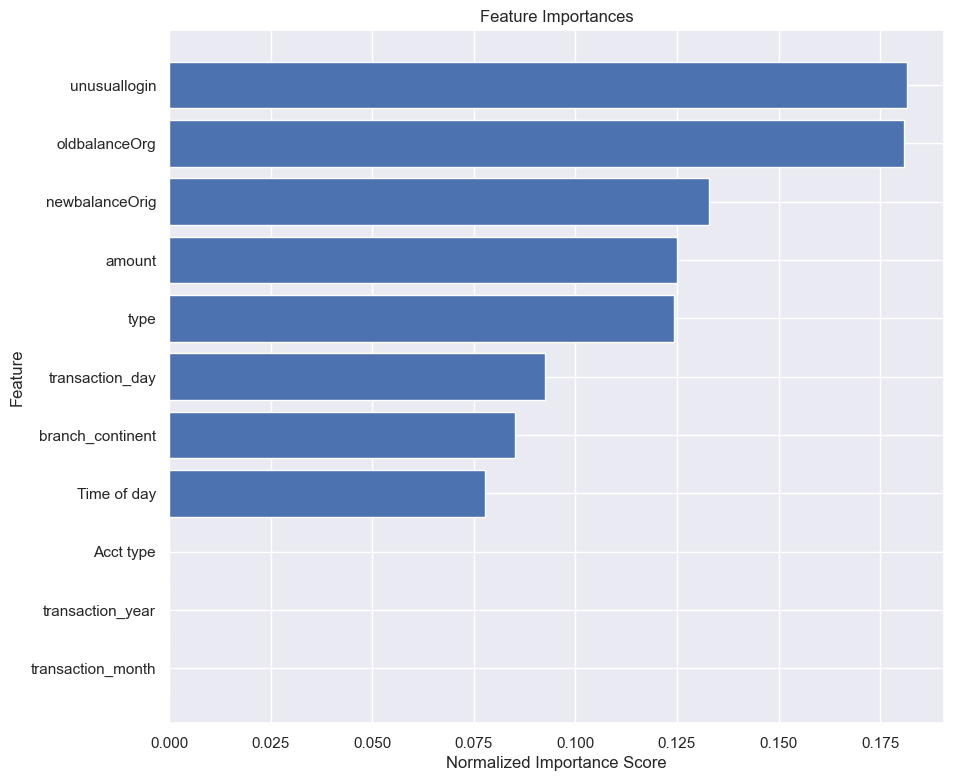

In [73]:
importances = best_xgb_model.feature_importances_

importances = importances / importances.sum()

importance_df = pd.DataFrame({
        'Feature':  X_train.columns,
        'Importance': importances
    }).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 9))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importances")
plt.xlabel("Normalized Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [74]:
importance_df

,Feature,Importance
4,unusuallogin,0.181714
2,oldbalanceOrg,0.180838
3,newbalanceOrig,0.132864
1,amount,0.124949
0,type,0.124273
10,transaction_day,0.092427
7,branch_continent,0.085229
6,Time of day,0.077707
5,Acct type,0.000000
8,transaction_year,0.000000


In [75]:
important_features_df = importance_df[importance_df['Importance'] > 0.01]
important_features_df

,Feature,Importance
4,unusuallogin,0.181714
2,oldbalanceOrg,0.180838
3,newbalanceOrig,0.132864
1,amount,0.124949
0,type,0.124273
10,transaction_day,0.092427
7,branch_continent,0.085229
6,Time of day,0.077707


In [76]:
important_features_df.Feature.tolist()

['unusuallogin',
 'oldbalanceOrg',
 'newbalanceOrig',
 'amount',
 'type',
 'transaction_day',
 'branch_continent',
 'Time of day']

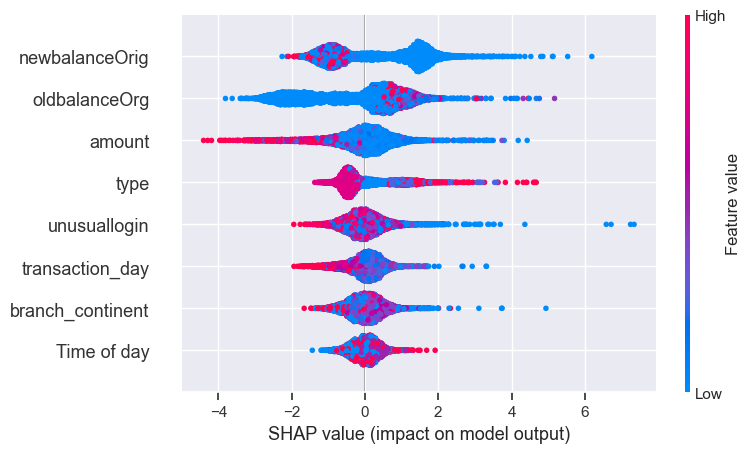

In [77]:
selected_features = [
 'unusuallogin',
 'oldbalanceOrg',
 'newbalanceOrig',
 'amount',
 'type',
 'transaction_day',
 'branch_continent',
 'Time of day'
]

explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_train)

shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_selected = shap_df[selected_features]
X_selected = X_train[selected_features]

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_selected.values, X_selected, show=False)
plt.tight_layout()
plt.show()

# 6. Build best model using final inputs

- train best selected model on final inputs , if result is higher than 40% model will proceed into production environment.

In [78]:
fin_input = new_data[important_features_df['Feature'].tolist()]
fin_output = data['isFraud']

X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(fin_input, fin_output, test_size=0.3, random_state=42)

In [79]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10)
    }

    xgb_clf = XGBClassifier(**param)
    auc = cross_val_score(xgb_clf, X_train_fin, y_train_fin, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model_fin = XGBClassifier(**best_params)

[I 2025-09-11 15:00:00,796] A new study created in memory with name: no-name-7c4466ba-eda5-49a5-a645-09c49432390c
[I 2025-09-11 15:00:04,500] Trial 0 finished with value: 0.776844676495076 and parameters: {'n_estimators': 618, 'learning_rate': 0.15200607907922078, 'max_depth': 4, 'subsample': 0.6236878339231958, 'colsample_bytree': 0.9283303733167243, 'gamma': 8}. Best is trial 0 with value: 0.776844676495076.
[I 2025-09-11 15:00:07,142] Trial 1 finished with value: 0.7506339925717779 and parameters: {'n_estimators': 328, 'learning_rate': 0.41783044904971206, 'max_depth': 9, 'subsample': 0.8022046234256324, 'colsample_bytree': 0.6013139440867578, 'gamma': 0}. Best is trial 0 with value: 0.776844676495076.
[I 2025-09-11 15:00:09,754] Trial 2 finished with value: 0.7788746113517804 and parameters: {'n_estimators': 347, 'learning_rate': 0.1527150715446084, 'max_depth': 7, 'subsample': 0.7344199751457234, 'colsample_bytree': 0.8205612062738927, 'gamma': 9}. Best is trial 2 with value: 0.77

Best trial:
  Value: 0.791
  Params:  {'n_estimators': 742, 'learning_rate': 0.49842887858607954, 'max_depth': 10, 'subsample': 0.7945081875269562, 'colsample_bytree': 0.5490772770959371, 'gamma': 4}


In [80]:
train_and_evaluate_model('Best XGB model', best_xgb_model_fin, X_train_fin, y_train_fin, X_test_fin, y_test_fin)

Model Performance for Best XGB model
Train Gini prob is 83.39528784463329
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7008
           1       0.96      0.33      0.49        79

    accuracy                           0.99      7087
   macro avg       0.98      0.66      0.74      7087
weighted avg       0.99      0.99      0.99      7087

[[7007    1]
 [  53   26]]
Model Performance for Best XGB model
Test Gini prob is 65.04133856584673
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2999
           1       1.00      0.13      0.23        39

    accuracy                           0.99      3038
   macro avg       0.99      0.56      0.61      3038
weighted avg       0.99      0.99      0.98      3038

[[2999    0]
 [  34    5]]


[np.float64(0.8339528784463328), np.float64(0.6504133856584673)]

# 7. Deployment

- Deploy model on fraud_deploy_data.xlsx
- Create 'probability of fraud' 
- Extract data where 'probability of fraud' is higher than 10%

In [106]:
data1 = pd.read_excel(r'fraud_deploy_data.xlsx')
data1.head()


,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,id
0,CASH_OUT,Irak,386683.04,C1373577787,0.00,0.00,C33524623,12,0,Savings,7/1/2018,Morning,1
1,PAYMENT,Estados Unidos,504.83,C49365994,608907.09,608402.27,M1529649769,8,0,Savings,13/1/2018,Afternoon,2
2,PAYMENT,Costa de Marfil,9805.46,C480184864,0.00,0.00,M1433956626,19,0,Savings,7/1/2018,Morning,3
3,CASH_OUT,Mexico,54395.20,C391915263,587.49,0.00,C1531333864,9,0,Current,6/1/2018,Afternoon,4
4,PAYMENT,Argelia,24258.10,C247576438,394.00,0.00,M775635860,7,0,Savings,11/1/2018,Night,5


In [107]:
data1['Date of transaction'] = pd.to_datetime(data1['Date of transaction'], dayfirst=True)

In [108]:
data1['transaction_day'] = data1['Date of transaction'].dt.day


In [109]:
print(data1['branch'].value_counts(dropna=False).to_string())

branch
Estados Unidos                     131
Australia                           75
Mexico                              73
Francia                             60
Alemania                            44
China                               41
India                               40
Brasil                              39
Reino Unido                         37
Indonesia                           36
Italia                              35
Espana                              20
El Salvador                         19
Honduras                            18
Republica Dominicana                17
Cuba                                17
Turquia                             17
Nueva Zelanda                       16
Guatemala                           16
Filipinas                           15
Nigeria                             12
Nicaragua                           11
Arabia Saudi                        11
Egipto                              10
Colombia                            10
Rusia             

In [111]:

country_to_continent = {
    # North America
    'Estados Unidos': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',
    'Panama': 'North America',
    'Honduras': 'North America',
    'El Salvador': 'North America',
    'Nicaragua': 'North America',
    'Republica Dominicana': 'North America',
    'Costa Rica': 'North America',
    'Guatemala': 'North America',
    'Cuba': 'North America',
    'Bahamas': 'North America',
    'Haiti': 'North America',
    'Jamaica': 'North America',
    'Trinidad y Tobago': 'North America',
    # South America
    'Brasil': 'South America',
    'Argentina': 'South America',
    'Colombia': 'South America',
    'Venezuela': 'South America',
    'Peru': 'South America',
    'Chile': 'South America',
    'Bolivia': 'South America',
    'Ecuador': 'South America',
    'Paraguay': 'South America',
    'Uruguay': 'South America',
    # Europe
    'Alemania': 'Europe',
    'Francia': 'Europe',
    'Italia': 'Europe',
    'Espana': 'Europe',
    'Suecia': 'Europe',
    'Noruega': 'Europe',
    'Portugal': 'Europe',
    'Austria': 'Europe',
    'Belgica': 'Europe',
    'Finlandia': 'Europe',
    'Polonia': 'Europe',
    'Irlanda': 'Europe',
    'Republica Checa': 'Europe',
    'Rumania': 'Europe',
    'Ucrania': 'Europe',
    'Russia': 'Europe',
    'Ucrania': 'Europe',
    # Asia
    'India': 'Asia',
    'China': 'Asia',
    'Indonesia': 'Asia',
    'Pakistan': 'Asia',
    'Japon': 'Asia',
    'Vietnam': 'Asia',
    'Corea del Sur': 'Asia',
    'Iran': 'Asia',
    'Irak': 'Asia',
    'Filipinas': 'Asia',
    'Malasia': 'Asia',
    'Nepal': 'Asia',
    'Camboya': 'Asia',
    # Africa
    'Nigeria': 'Africa',
    'Egipto': 'Africa',
    'Sudafrica': 'Africa',
    'Senegal': 'Africa',
    'Marruecos': 'Africa',
    'Angola': 'Africa',
    'Etiopia': 'Africa',
    'Uganda': 'Africa',
    'Camerun': 'Africa',
    'Zimbabue': 'Africa',
    'Sudan': 'Africa',
    # Oceania
    'Australia': 'Oceania',
    'Nueva Zelanda': 'Oceania',
    'Papua Nueva Guinea': 'Oceania',
    # Middle East 
    'Arabia Saudi': 'Asia',
    'Emiratos arabes Unidos': 'Asia',
    'Israel': 'Asia',

}

def map_country_to_continent(country):
    if country in country_to_continent:
        return country_to_continent[country]
    else:
        return 'Other'

data1['branch_continent'] = data1['branch'].apply(map_country_to_continent)


In [95]:
data1['branch_continent'] = data1['branch'].apply(map_country_to_continent)


In [112]:
data1

,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,id,transaction_day,branch_continent
0,CASH_OUT,Irak,386683.04,C1373577787,0.00,0.00,C33524623,12,0,Savings,2018-01-07,Morning,1,7.0,Asia
1,PAYMENT,Estados Unidos,504.83,C49365994,608907.09,608402.27,M1529649769,8,0,Savings,2018-01-13,Afternoon,2,13.0,North America
2,PAYMENT,Costa de Marfil,9805.46,C480184864,0.00,0.00,M1433956626,19,0,Savings,2018-01-07,Morning,3,7.0,Other
3,CASH_OUT,Mexico,54395.20,C391915263,587.49,0.00,C1531333864,9,0,Current,2018-01-06,Afternoon,4,6.0,North America
4,PAYMENT,Argelia,24258.10,C247576438,394.00,0.00,M775635860,7,0,Savings,2018-01-11,Night,5,11.0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,CASH_IN,Mexico,235409.03,C1538844412,10500000.00,10700000.00,C1538745405,13,0,Savings,2018-01-19,Night,1008,19.0,North America
1008,CASH_IN,Mexico,29351.64,C853343978,10000000.00,10100000.00,C187649742,20,0,Savings,2018-01-06,Afternoon,1009,6.0,North America
1009,CASH_OUT,Turquia,363482.02,C1457226878,25365.85,0.00,C1899073220,7,0,Savings,2018-01-13,Afternoon,1010,13.0,Other
1010,CASH_OUT,Alemania,31980.86,C1558129795,0.00,0.00,C257999182,13,0,Savings,2018-01-07,Morning,1011,7.0,Europe


In [113]:
fin_input.columns

Index(['unusuallogin', 'oldbalanceOrg', 'newbalanceOrig', 'amount', 'type',
       'transaction_day', 'branch_continent', 'Time of day'],
      dtype='object')

In [114]:
deploy_data = data1[['id','unusuallogin', 'oldbalanceOrg', 'newbalanceOrig', 'amount', 'type',
       'transaction_day', 'branch_continent', 'Time of day']]

deploy_data.head()

,id,unusuallogin,oldbalanceOrg,newbalanceOrig,amount,type,transaction_day,branch_continent,Time of day
0,1,12,0.00,0.00,386683.04,CASH_OUT,7.0,Asia,Morning
1,2,8,608907.09,608402.27,504.83,PAYMENT,13.0,North America,Afternoon
2,3,19,0.00,0.00,9805.46,PAYMENT,7.0,Other,Morning
3,4,9,587.49,0.00,54395.20,CASH_OUT,6.0,North America,Afternoon
4,5,7,394.00,0.00,24258.10,PAYMENT,11.0,Other,Night


In [115]:
deploy_data.dtypes 


id                    int64
unusuallogin          int64
oldbalanceOrg       float64
newbalanceOrig      float64
amount              float64
type                 object
transaction_day     float64
branch_continent     object
Time of day          object
dtype: object

In [116]:
for i in ['Time of day','type', 'branch_continent']:
    le = encoders[i]
    deploy_data[i] = le.transform(deploy_data[i])

deploy_data.head()

C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\3399620886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_data[i] = le.transform(deploy_data[i])
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\3399620886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_data[i] = le.transform(deploy_data[i])
C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\3399620886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,id,unusuallogin,oldbalanceOrg,newbalanceOrig,amount,type,transaction_day,branch_continent,Time of day
0,1,12,0.00,0.00,386683.04,1,7.0,1,1
1,2,8,608907.09,608402.27,504.83,3,13.0,3,0
2,3,19,0.00,0.00,9805.46,3,7.0,5,1
3,4,9,587.49,0.00,54395.20,1,6.0,3,0
4,5,7,394.00,0.00,24258.10,3,11.0,5,2


In [117]:
deploy_data['probability of fraud'] = best_xgb_model_fin.predict_proba(deploy_data.iloc[:,1:])[:,1]
deploy_data

C:\Users\Nurane2\AppData\Local\Temp\ipykernel_18796\3068273084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_data['probability of fraud'] = best_xgb_model_fin.predict_proba(deploy_data.iloc[:,1:])[:,1]


,id,unusuallogin,oldbalanceOrg,newbalanceOrig,amount,type,transaction_day,branch_continent,Time of day,probability of fraud
0,1,12,0.00,0.00,386683.04,1,7.0,1,1,0.001189
1,2,8,608907.09,608402.27,504.83,3,13.0,3,0,0.004287
2,3,19,0.00,0.00,9805.46,3,7.0,5,1,0.004048
3,4,9,587.49,0.00,54395.20,1,6.0,3,0,0.010819
4,5,7,394.00,0.00,24258.10,3,11.0,5,2,0.002243
...,...,...,...,...,...,...,...,...,...,...
1007,1008,13,10500000.00,10700000.00,235409.03,0,19.0,3,2,0.004067
1008,1009,20,10000000.00,10100000.00,29351.64,0,6.0,3,0,0.011265
1009,1010,7,25365.85,0.00,363482.02,1,13.0,5,0,0.089022
1010,1011,13,0.00,0.00,31980.86,1,7.0,2,1,0.014308


In [118]:
high_risk = deploy_data[deploy_data['probability of fraud'] > 0.1]
high_risk

,id,unusuallogin,oldbalanceOrg,newbalanceOrig,amount,type,transaction_day,branch_continent,Time of day,probability of fraud
78,79,8,140821.40,0.00,285656.95,1,5.0,5,0,0.230538
149,150,7,25099.30,10119.47,14979.83,1,3.0,3,1,0.138616
405,406,13,87495.57,0.00,117762.75,1,8.0,6,0,0.198522
419,420,13,7020.58,0.00,41624.47,1,6.0,3,0,0.101068
435,436,1,120074.73,0.00,120074.73,1,3.0,3,0,0.305129
586,587,1,0.00,0.00,41924.75,1,10.0,5,2,0.127650
608,609,1,4709.52,929.05,3780.47,3,9.0,4,0,0.109232
609,610,11,53339.25,0.00,74935.58,1,3.0,3,2,0.109328
679,680,15,35239.99,0.00,47317.52,1,6.0,6,2,0.138948
747,748,8,26845.41,0.00,110414.71,1,3.0,1,0,0.132013
